<a href="https://colab.research.google.com/github/morcellinus/2021_NH_BigData_Contest/blob/main/%EB%AA%A8%EB%8D%B8%20%EC%84%A4%EB%AA%85%EC%84%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### A. 선택 모델 

* 예측 모형은 앙상블 부스팅 알고리즘 모델인 XGBOOST를 사용합니다.

* 부스팅 알고리즘은 여러 개의 의사결정나무 (Decision Tree) 모델을 조합해 강한 모델을 만드는 앙상블 모델의 일종으로,<br>   기존의 그라디언트 부스팅 모델보다 좋은 성능을 보입니다. 

* 학습을 진행하며 이전 단계의 오차에 따른 가중치를 업데이트 한 후 다음 단계에 반영하기 때문에 정확한 예측이 가능합니다. 

#### B. Train Data에 hist_d를 생성하기 위한 외부데이터 

* 주어진 Test data에는 hist_d라는 칼럼이 존재합니다.<br>
* 이 칼럼은 주식 보유자가 주식을 판매한 해(2021년)의 직전 해의 마지막 영업일을 기준으로 보유기간을 자른 수치를 담고 있습니다. <br>
* 예를 들어서 2017년 8월에 구매한 주식을 2021년 4월에 팔았다면 <br> 2017년 8월부터 2020년의 마지막 영업일까지의 기간을 담고 있는 셈입니다. <br>
* 그러나 Train data에는 이 hist_d 칼럼이 존재하지 않습니다.
<br>
<br>
* 또 하나의 문제는 데이터 상에 주어진 hold_d가 실제 달력 상의 기간이 아니라는 점입니다.<br>
* hold_d는 주식시장 영업일만을 count한 기간입니다. 따라서 그 수치가 실제 달력상 기간보다 큽니다. <br>
<br>

* 따라서 다음과 같은 분석 방법을 적용했습니다.<br>
1. 주식 시장 영업일을 갖고 있는 외부 데이터를 불러온다.
2. Train data의 주식 구매 날짜를 나타내는 칼럼인 byn_dt에 hold_d 만큼의 영업일이 더해진 '판매날짜'를 구한다. <br>
3. 구해진 판매날짜로부터 판매년도를 추출해 구매년도와 차이가 있는지 확인한다. <br>
4. 이중 판매년도의 직전년도 마지막 영업일에 맞춰 영업일 기준으로 hist_d를 구한다. <br> 이렇게 한 이유는 Test data에서 hist_d를 구한 방식과 동일하게 Train data에서도 hist_d를 구하기 위함이다.
<br>
<br>
* 아래는 이 과정 중 외부 데이터를 가져와 분석에 맞게 전처리하고 hist_d를 찾는 과정에 대한 설명입니다.


##### B_1) data source: 
##### 증권 영업일 데이터

* exchange_calendars: 오픈 소스 라이브러리로 증권사 영업일 데이터를 생성합니다.

In [ ]:
'''
!pip install exchange_calendars

##### B_2) 데이터 수집 방법: 
<br>

* 2016년 1월 4일부터 2020년 12월 31까지의 영업일을 저장한 xkrx_df 데이터프레임을 만들고, <br>원 데이터와 형식을 맞춰서 영업일을 저장했습니다.

In [ ]:
'''
import exchange_calendars as ecals 
import datetime
import pytz
import pandas as pd
XKRX = ecals.get_calendar("XKRX") # 한국 코드 
xkrx_cal=XKRX.sessions_in_range(
    pd.Timestamp('20160104', tz=pytz.UTC),
   pd.Timestamp('20201231', tz=pytz.UTC))
#2016일 1월 4일부터 2020년 12월 31일까지의 한국 거래일 날짜들 데이터프레임으로
import re
xkrx_df=xkrx_cal.to_frame(index=False, name='영업일')
xkrx_df['영업일']=xkrx_df['영업일'].dt.date
xkrx_df['영업일']=xkrx_df['영업일'].apply(lambda x: str(x))
xkrx_df['영업일']=xkrx_df['영업일'].apply(lambda x: re.sub("-","",x))
##원 데이터와 형식 맞추기
xkrx_df['영업일']=xkrx_df['영업일'].apply(lambda x: int(x))

xkrx_df.head()

##### B_3) 전처리 : 
##### 파생변수 생성
<br>

* xkrx_df를 활용하여 byn_dt로부터 hold_d만큼 계좌를 보유한 것을 계산하여 판매날짜 column을 생성했습니다.

* 이후에도 byn_dt에서 주식 구매년도를 구하고, 판매날짜 열에서 판매년도라는 파생변수를 만들었습니다.

In [ ]:
'''
import pandas as pd
import numpy as np


cus = pd.read_csv("open/cus_info.csv")
iem = pd.read_csv("open/iem_info_20210902.csv")
hist = pd.read_csv("open/stk_bnc_hist.csv")
train = pd.read_csv("open/stk_hld_train.csv")
test = pd.read_csv("open/stk_hld_test.csv")
submission = pd.read_csv("open/sample_submission.csv")

pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])
hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

In [ ]:
'''
def find_day(df,idx,hold_d):

  # 보유일자 10일; 6월 1일에 구매했다 : 6월 10일에 판매했다
    new=idx+hold_d-1
    return df.iloc[new,0]

In [ ]:
'''
train_data['판매날짜']=''
for j in range(len(train_data)):
    day=train_data.iloc[j,2]
    hold_d=train_data.iloc[j,3]
    idx=xkrx_df[xkrx_df['영업일']==day].index
    train_data.loc[j,'판매날짜']=find_day(xkrx_df,idx,hold_d).values

##### B_4) 추가 전처리:
<br>

* byn_dt에서 주식 구매년도를 구하고, 판매날짜 열에서 판매년도라는 파생변수를 생성했습니다.

In [ ]:
'''
판매_train['구매년도']=판매_train['byn_dt']//10000
판매_train['판매년도']=판매_train['판매날짜']//10000

##### B_5) 활용방안 및 지속성: 
<br>

* train_data의 hist_d 설정

* test_d에서의 hist_d는 21년 판매하는 종목에 대해 구매일자 ~ 20년 12월 30일의 보유기간을 나타내므로 <br>train_data에서 hist_d 또한 구매년도와 판매년도가 다른 데이터를 가지고 계산했습니다. <br>
(ex) 16년 구매, 20년 판매 : 구매일자~ 19년 마지막 영업일까지의 보유기간 = hist_d<br>
* 사용한 외부데이터는 영업일마다 업데이트 되기 때문에 지속적으로 사용이 가능합니다.

In [ ]:
'''
def find_histd17(day): #판매년도 17년도
    idx=xkrx_df[xkrx_df['영업일']==day].index
    idx=idx.values
    hist_d=245-idx
    return hist_d
#245는 xkrx_df에서 2016년 마지막 영업일의 인덱스값

def find_histd18(day): #판매년도 18년
    idx=xkrx_df[xkrx_df['영업일']==day].index
    idx=idx.values
    hist_d=488-idx
    return hist_d
#488은 xkrx_df에서 2017년 마지막 영업일의 인덱스값

def find_histd19(day): #판매년도 19년도
    idx=xkrx_df[xkrx_df['영업일']==day].index
    idx=idx.values
    hist_d=732-idx
    return hist_d
#732는 xkrx_df에서 2018년 마지막 영업일의 인덱스값
def find_histd(day): #판매년도 20년도
    idx=xkrx_df[xkrx_df['영업일']==day].index
    idx=idx.values
    hist_d=978-idx
    return hist_d
#978은 xkrx_df에서 2019년 마지막 영업일의 인덱스값

target_17=target_data[target_data['판매년도']==2017]
target_17['hist_d']=''
target_17['hist_d']=target_17['byn_dt'].apply(lambda x: find_histd17(x))
target_17['hist_d'] = target_17['hist_d'].astype(str).str.replace(r"[^0-9]","").astype(float)

target_18=target_data[target_data['판매년도']==2018]
target_18['hist_d']=''
target_18['hist_d']=target_18['byn_dt'].apply(lambda x: find_histd18(x))
target_18['hist_d'] = target_18['hist_d'].astype(str).str.replace(r"[^0-9]","").astype(float)

target_19=target_data[target_data['판매년도']==2019]
target_19['hist_d']=''
target_19['hist_d']=target_19['byn_dt'].apply(lambda x: find_histd19(x))
target_19['hist_d'] = target_19['hist_d'].astype(str).str.replace(r"[^0-9]","").astype(float)

target2=target_data[target_data['판매년도']==2020]
target2['hist_d']=''
target2['hist_d']=target2['byn_dt'].apply(lambda x: find_histd(x))
target2['hist_d'] = target2['hist_d'].astype(str).str.replace(r"[^0-9]","").astype(float)

targets=pd.concat([target2,target_17,target_18,target_19])
targets.reset_index(drop=True,inplace=True)
targets

#### C. 분석 범주 : 오버샘플링 

* 이렇게 Train data에도 영업일을 기준으로 Test data와 같은 logic을 사용해 hist_d를 만들었습니다. <br>
* 그리고 이 중 "구매년도 < 판매년도"인 경우만을 남겨 모델링을 진행하려 시도했습니다. <br>
* 그 이유는 **Test data**의 모든 obs는 "주식 보유 기간 중 해가 바뀐 경우"이기 때문입니다. <br>
* 즉, 2019년에 사서 2019년에 판 경우는 Test data에 없고, 모두 2021년 이전에 구매해서 2021년에 판매한 경우입니다. <br>
* 하지만 Train data의 모든 row 중 주식 보유 기간 내에 해가 바뀐 경우는 약 5%에 불과합니다. <br>
* 따라서 Train data에서 해당 경우를 만족하는 row만 남기게 되면, Test data보다 적은 Train data로 모델링을 해야 하는 문제가 발생합니다.
<br>
<br>
* 이를 해결하기 위해 Train data에서 해당 경우를 만족하는 row의 수를 증폭시키기 위한 Oversampling 방법을 적용했습니다.<br>
* 판매날짜와 hist_d를 만들어낸 Train data에서 해당 경우를 만족하는 5%정도의 row들을 증폭시켜서 <br>Test data와 유사한 Train data를 만들어내는 방법입니다. <br>
* Oversampling 방법 중 가장 간단한 방법은 <U>Random Oversampling</U>입니다.<br>
* 소수 클래스 중 random하게 obs를 뽑아 단순 복제하여 비율을 맞춰주는 원리입니다. <br>다만 데이터가 동일하게 증폭되다보니 오버피팅에 취약합니다. 
<br>
<br>
* <U>**따라서 과적합을 방지하기 위해 SMOTE Oversampling을 사용했습니다.**</U> 
<br>
* SMOTE는 임의의 소수 클래스 데이터의 인근에 새로운 데이터를 생성하는 방식입니다.<br>
* 이 때 인근의 데이터를 찾는 방법은 KNN 알고리즘을 사용합니다.<br>
* 유클리드 거리를 기준으로 K개의 인근 데이터를 찾고, 원본 소수 클래스 데이터와 인근 데이터 사이에 직선을 긋습니다.<br>
* 그 직선 상의 랜덤한 포인트에 데이터를 임의로 생성하는 방법이 SMOTE입니다.
<br>
<br>
* Oversampling을 적용하기 위해선 Train data에 가짜 종속변수를 생성해주어야 합니다.<br>
* 우리의 Train data에서 소수 클래스는 <U>보유기간 중 해가 바뀐 경우</U>이고 다수 클래스는 <U> 보유기간 중 해가 바뀌지 않은 경우</U>입니다. <br>
* 따라서 구매년도와 판매년도를 비교해, <U>판매년도와 구매년도의 차이가 있으면 1, 없으면 0의 값을 갖는 **fake_y** 변수</U>를 생성했습니다.<br>
* 이에 따라 우리의 Train data는 소수클래스 1과 다수 클래스 0을 갖는 데이터가 되었습니다. <br>
* 이 데이터를 가지고 SMOTE Oversampling으로 소수 클래스를 증폭시켜 <U>총 1,293,204개의 row를 갖는 Train data</U>를 만들었습니다.
<br>
* K의 값은 10으로 설정했습니다. <br>
* 이후 우리에게 필요한 Train data는 <U>보유 기간 중 해가 바뀐 경우</U>, 즉 <U>fake_y의 값이 1인 경우</U>이므로 <br>해당 경우만을 남기고 나머지 row를 drop 했습니다.

#### D. 모델링

##### D_1) 모델 파라미터:

* XGBoost는 다양한 모델 파라미터로 성능을 높이고 과적합을 방지할 수 있습니다.

* 저희는 아래의 파라미터를 모두 사용했습니다.

 * learning rate 

 * max_depth

 * n_estimators

 * min_child_weight

 * subsample

 * scale_pos_weight

 * alpha





###### D_2) 모델 파라미터 설명: 

* **learning rate**는 학습률로, 경사하강법을 적용해 손실을 최소화하는 방향으로 학습할 때 나아가는 스텝의 크기를 의미합니다. 값이 지나치게 크면 과적합이 발생하고 지나치게 작으면 학습 시간이 너무 길어집니다.

* **max_depth**는 사용되는 decision tree를 얼마나 분기할지 정해주는 파라미터로, 역시 값이 너무 크면 과적합이 발생합니다.

* **n_estimators**는 학습에서 생성할 weak estimator의 개수로, learning rate가 작게 설정되었다면 n_estimators를 크게 설정해<br> 과적합을 방지할 수 있습니다.<br> 데이터셋의 크기에 따라 경험적으로 좋은 값이 제시되어 있습니다.

* **min_child_weight**은 각 단계에서 적용되는 가중치의 최소 합을 의미합니다. 값이 클수록 과적합이 방지됩니다.

* **subsample**은 각각의 decision tree가 사용하는 샘플의 비율을 의미합니다. 값이 낮을수록 과적합이 방지됩니다.

* **alpha**는 가중치에 대한 L1 regularization(Lasso penalty) 적용 값으로 데이터의 피쳐가 많을 경우 사용을 고려합니다. <br>값이 클수록 과적합이 방지됩니다.


##### D_3) 모델 파라미터 값: 

* Grid Search 교차검증과 Heuristic한 방법으로 위 파라미터에 대한 값을 아래와 같이 설정했습니다.

 * learning rate: 0.01

 * max_depth: 5

 * n_estimators: 1000 

 * min_child_weight: 2

 * subsample: 0.6

 * alpha: 1

##### D_4) 변수 선택: 

* 채택된 변수는 xgboost 변수 선택법을 통해 정했습니다.

* 변수 선택법을 진행한 결과 <br> **['hist_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd',
'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',  'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm','btp_cfc_cd', 
 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'bnc_qty', <br>'tot_aet_amt', 'stk_par_pr', 'stk_p']**이 나왔습니다.
 
* 나머지 변수선택 과정과 전처리 과정은 Baseline Code와 동일하게 진행했으며, 다른 방법을 시도해도 RMSE 값이 개선되지 않았습니다. 

##### D_5) 모델링 과정:

* 위에 제시한 모델 파라미터와 변수를 가지고 XGBoost Regressor를 사용해 예측을 수행했습니다. <br>
* 예측 과정에서 <U>5-fold Cross Validation</U>을 사용했습니다.
* Train data를 5개의 fold로 나누어 한 fold씩 돌아가며 Test data의 역할을 수행하는 방식입니다.<br>
* 새로운 데이터셋에 대해 적합되는 과정이 다섯 번 반복되기 때문에 Test data에 대해서도 robust한 모델이 만들어집니다. 
* 모델링 결과 Leader Board 상에서 RMSE 값 56.7618까지 달성했습니다.

#### E. visualization
<br>

* 데이터의 분포를 확인하기 위해 종목별 hold_d를 확인해본다면 아래의 결과가 나옵니다.

##### E_1) Train data의 종목별 hold_d
<br>

* 평균은 10 미만

* 대부분의 데이터가 20 미만의 보유일이고, 그 기간을 넘어가는 장기 투자의 경우 "이상치" 로 구분됩니다.


Text(0.5, 1.0, '전체 train의 종목별 hold_d')

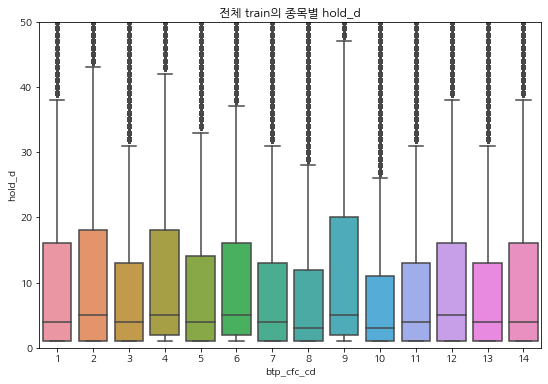

In [ ]:
'''
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(1, figsize=(9, 6))
sns.boxplot(x='btp_cfc_cd',y='hold_d',data=판매_train)
plt.ylim(0,50)
plt.title("전체 train의 종목별 hold_d")


#####  E_2) Train data 중 (구매년도<판매년도)의 종목별 hist_d와 test_data의 종목별 hist_d 비교
<br>

* 평균은 50~75 사이

* test_data의 경우, hist_d만 존재하기 때문에, train_data에 구매일~ 판매년도 1년 전 마지막 영업일까지의 보유일로 hist_d를 생성하여<br>hist_d끼리 비교를 진행했습니다.

* Train data에서 전체 보유일을 나타내는 hold_d는 test_d의 hist_d보다도 보유일이 낮아 test_data와 간극이 크다는 것을 보여줍니다.

* 반면 Train data 중 (구매년도<판매년도)만 남기면 test_data와 분포가 유사한 것을 알 수 있습니다.

* 이와 같은 이유로 원래 Train data에서 가짜 종속변수를 만들고 (구매년도<판매년도)인 경우만 Over sampling 하여 학습을 진행한 것입니다.

Text(0.5, 1.0, 'test_data의 종목별 hist_d')

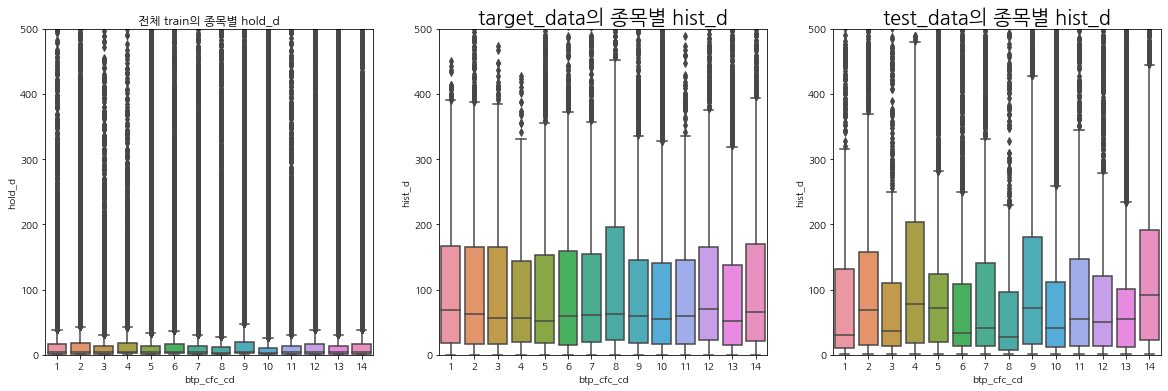

In [ ]:
'''
fig = plt.figure(1, figsize=(20, 6))
plt.subplot(131)
sns.boxplot(x='btp_cfc_cd',y='hold_d',data=판매_train)
plt.ylim(0,500)
plt.title("전체 train의 종목별 hold_d")
plt.subplot(132)
sns.boxplot(x='btp_cfc_cd',y='hist_d',data=targets)
plt.ylim(0,500)
plt.title("target_data의 종목별 hist_d",fontsize=20)
plt.subplot(133)
sns.boxplot(x='btp_cfc_cd',y='hist_d',data=test_data)
plt.ylim(0,500)
plt.title("test_data의 종목별 hist_d",fontsize=20)

#### F. 기타

* Train data 중에서 "판매년도 < 구매년도"가 아닌 경우에도 적절하게 hist_d를 구할 수 없었는가?<br>
* 위와 같은 시도를 위해 아래의 방법들을 사용했습니다.

1. baseline처럼 hold_d*0.6

2. 구매년도와 판매년도가 다른 target data에서 rate( hist_d/hold)를 구한 다음, train_same의 hold_d에 시간대별,종목별 rate를 곱한다


In [ ]:
'''
others=판매_train[판매_train['구매년도']==판매_train['판매년도']]
others['hist_d']=others['hold_d']*0.6
others.hist_d=np.trunc(others["hist_d"])

In [ ]:
'''
targets2=targets.copy()
targets2['rate']=target2['hist_d']/target2['hold_d']
RATE=targets2.groupby(['btp_cfc_cd'],as_index=False)['rate'].mean()
others=판매_train[판매_train['구매년도']==판매_train['판매년도']]
others=pd.merge(others,RATE,how='left',on='btp_cfc_cd')
others['hist_d']=others['hold_d']*others['rate']
others.drop(['rate'],axis=1,inplace=True)
others.hist_d=np.trunc(others["hist_d"])
others['hist_d']=others['hist_d'].apply(lambda x: int(x))
others

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,판매날짜,구매년도,판매년도,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,1,9,3,2,2,9,5,5,8,GS건설,1,1,1,20180726,274.0,11782000.0,5000.0,43000.0,20180809,2018,2018,6
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,1,9,3,2,2,9,5,5,8,삼성전자,9,1,1,20180131,2.0,4990000.0,5000.0,2495000.0,20180530,2018,2018,50
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,1,9,3,2,2,9,5,5,8,코스모신소재,12,2,99,20180517,786.0,14619600.0,1000.0,18600.0,20180524,2018,2018,2
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,1,9,3,2,2,9,5,5,8,영진약품,8,2,1,20201112,60.0,462000.0,500.0,7700.0,20201211,2020,2020,10
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002230,20180806,98,1,9,3,2,2,9,5,5,8,피에스텍,10,3,99,20180806,700.0,4039000.0,500.0,5770.0,20181228,2018,2018,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649988,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,1,4,4,2,2,3,4,3,8,알리코제약,10,3,99,20180831,199.0,3532250.0,500.0,17750.0,20180831,2018,2018,0
649989,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,1,4,4,2,2,3,4,3,8,제일약품,8,2,99,20201027,488.0,22960400.0,500.0,47050.0,20201027,2020,2020,0
649990,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,1,4,4,2,2,3,4,3,8,SV인베스트먼트,2,2,99,20181121,2210.0,9204650.0,500.0,4165.0,20181121,2018,2018,0
649991,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,20200214,1,1,4,4,2,2,3,4,3,8,컴퍼니케이,2,3,99,20200214,285.0,2721750.0,500.0,9550.0,20200214,2020,2020,0


In [ ]:
'''
RATE

,btp_cfc_cd,rate
0,1,0.595353
1,2,0.654018
2,3,0.559179
3,4,0.662098
4,5,0.571115
5,6,0.563183
6,7,0.642975
7,8,0.461948
8,9,0.628530
9,10,0.621067


* 그러나 일괄적으로 어떠한 수치 (ex, 0.6)를 hold_d에 곱해 hist_d를 생성하거나<br> 여러가지 column으로 group_by를 하여 투자자의 나이나 성향, 종목별로 hist_d와 hold_d의 비율을 곱해 해당하는 경우에 곱해도<br>
모델의 성능은 좋아지지 않았습니다.
<br>
* 오히려 전체 데이터에서 "판매년도 < 구매년도"인 5%에 해당하는 row만 남기고 Test data보다도 적은 데이터로<br> 모델을 학습했을 때 위의 경우를 시도했을 때보다 모델 성능이 좋았습니다.
<br>
* 이러한 이유로 이전에 언급한 오버 샘플링을 사용했습니다.

